# Tutorial: Detección de Anomalías con KNN y PCA

*GSDPI 2026, Universidad de Oviedo*

[gsdpi.edv.uniovi.es](https://gsdpi.edv.uniovi.es)

Este notebook es un tutorial educativo para comparar diferentes métodos de detección de anomalías en datos de aceleración del dataset ICANN.

## Objetivos
1. Cargar y preparar datos de aceleración (solo canal `ax`)
2. Aplicar enventanado a las series temporales
3. Detectar anomalías con **KNN** (K Nearest Neighbors)
4. Detectar anomalías con **PCA** (Principal Component Analysis)
5. Comparar el rendimiento de ambos métodos

## Estructura
- **Datos de entrenamiento**: Experimentos normales (sin anomalías)
- **Datos de test válidos**: Nuevos datos normales (sin anomalías)
- **Datos de test con anomalías**: Datos anómalos a detectar

## 1. Importar Librerías Necesarias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Configuración de gráficos
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.size'] = 12

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


## 2. Cargar y Preparar Datos ICANN

El dataset ICANN contiene datos de aceleraciones de un motor eléctrico en diferentes condiciones.

### Estructura de experimentos:
- **Experimentos 2, 6, 3, 4, 5**: Datos normales (entrenamiento)
- **Experimentos 7, 8**: Datos normales (test válido)
- **Experimentos 0, 1**: Datos con anomalías (test anómalo)

Usaremos solo la aceleración **`ax`** (eje X) para simplificar el análisis.

In [ ]:
# Cargar datos del archivo .mat
data = loadmat('../../datos/dataicann.mat')

# Mapeo de experimentos a su tipo
experiment_mapping = {
    2: 0, 6: 5, 3: 10, 4: 15, 5: 20,  # Normales (entrenamiento, valores de resistencia conocidos)
    7: np.nan, 8: np.nan,              # Normales (test válido, valores de resistencia desconocidos)
    0: np.nan, 1: np.nan,              # Anomalías (test anómalo, fallo mecánico)
}

# Definir conjuntos de experimentos
train_experiments = [2, 6, 3, 4, 5]      # Para entrenar el modelo
test_valid_experiments = [7, 8]          # Test normal (sin anomalías)
test_anomaly_experiments = [0, 1]        # Test con anomalías

# Extraer datos de cada experimento
all_data = []
all_labels = []
all_exp_ids = []

for exp_id in experiment_mapping.keys():
    exp_data = data['z'][0][exp_id]  # Forma: (n_samples, 5) con columnas [ac, ax, ay, ir, is]
    n_samples = exp_data.shape[0]
    
    all_data.append(exp_data)
    all_exp_ids.append(np.repeat(exp_id, n_samples))
    all_labels.append(np.repeat(experiment_mapping[exp_id], n_samples))

# Concatenar todos los datos
all_data = np.vstack(all_data)
all_exp_ids = np.concatenate(all_exp_ids)
all_labels = np.concatenate(all_labels)

# Crear DataFrame
df = pd.DataFrame(all_data, columns=['ac', 'ax', 'ay', 'ir', 'is'])
df.insert(0, 'experiment', all_exp_ids)
df['resistance'] = all_labels

# Seleccionamos solo la columna 'ax' (aceleración en eje X)
print(f"✓ Datos cargados: {len(df)} muestras totales")
print(f"  - Columnas disponibles: {list(df.columns)}")
print(f"  - Usaremos solo: 'ax' (aceleración en eje X)")
print(f"\nDistribución de experimentos:")
print(df['experiment'].value_counts().sort_index())

✓ Datos cargados: 209920 muestras totales
  - Columnas disponibles: ['experiment', 'ac', 'ax', 'ay', 'ir', 'is', 'resistance']
  - Usaremos solo: 'ax' (aceleración en eje X)

Distribución de experimentos:
experiment
0    19968
1    19968
2    19968
3    19968
4    19968
5    19968
6    19968
7    19968
8    50176
Name: count, dtype: int64


In [4]:
# Separar datos en entrenamiento, test válido y test anómalo
# Seleccionamos solo la columna 'ax' para cada conjunto

# 1. DATOS DE ENTRENAMIENTO (normales)
train_data = []
for exp_id in train_experiments:
    exp_signal = df[df['experiment'] == exp_id]['ax'].values
    train_data.append(exp_signal)

# Concatenar todos los experimentos de entrenamiento
X_train = np.concatenate(train_data)

print("=" * 60)
print("DATOS DE ENTRENAMIENTO (normales)")
print("=" * 60)
print(f"✓ Experimentos: {train_experiments}")
print(f"✓ Total de muestras: {len(X_train)}")
print()

# 2. DATOS DE TEST VÁLIDOS (normales, sin anomalías)
test_valid_data = []
for exp_id in test_valid_experiments:
    exp_signal = df[df['experiment'] == exp_id]['ax'].values
    test_valid_data.append(exp_signal)

X_test_valid = np.concatenate(test_valid_data)

print("=" * 60)
print("DATOS DE TEST VÁLIDOS (normales, sin anomalías)")
print("=" * 60)
print(f"✓ Experimentos: {test_valid_experiments}")
print(f"✓ Total de muestras: {len(X_test_valid)}")
print()

# 3. DATOS DE TEST CON ANOMALÍAS
test_anomaly_data = []
for exp_id in test_anomaly_experiments:
    exp_signal = df[df['experiment'] == exp_id]['ax'].values
    test_anomaly_data.append(exp_signal)

X_test_anomaly = np.concatenate(test_anomaly_data)

print("=" * 60)
print("DATOS DE TEST CON ANOMALÍAS")
print("=" * 60)
print(f"✓ Experimentos: {test_anomaly_experiments}")
print(f"✓ Total de muestras: {len(X_test_anomaly)}")
print()

# Combinar test válido y anómalo para evaluación
X_test_combined = np.concatenate([X_test_valid, X_test_anomaly])

# Crear etiquetas: 1 = normal, 0 = anomalía
y_test_combined = np.concatenate([
    np.ones(len(X_test_valid)),   # Test válido = 1 (normal)
    np.zeros(len(X_test_anomaly))  # Test anómalo = 0 (anomalía)
])

print("=" * 60)
print("DATOS DE TEST COMBINADOS (para evaluación)")
print("=" * 60)
print(f"✓ Total test: {len(X_test_combined)} muestras")
print(f"  - Normales: {int(y_test_combined.sum())} muestras")
print(f"  - Anomalías: {int((1 - y_test_combined).sum())} muestras")

DATOS DE ENTRENAMIENTO (normales)
✓ Experimentos: [2, 6, 3, 4, 5]
✓ Total de muestras: 99840

DATOS DE TEST VÁLIDOS (normales, sin anomalías)
✓ Experimentos: [7, 8]
✓ Total de muestras: 70144

DATOS DE TEST CON ANOMALÍAS
✓ Experimentos: [0, 1]
✓ Total de muestras: 39936

DATOS DE TEST COMBINADOS (para evaluación)
✓ Total test: 110080 muestras
  - Normales: 70144 muestras
  - Anomalías: 39936 muestras


## 3. Visualizar Datos

Veamos cómo se ven las señales de entrenamiento, test válido y test con anomalías.

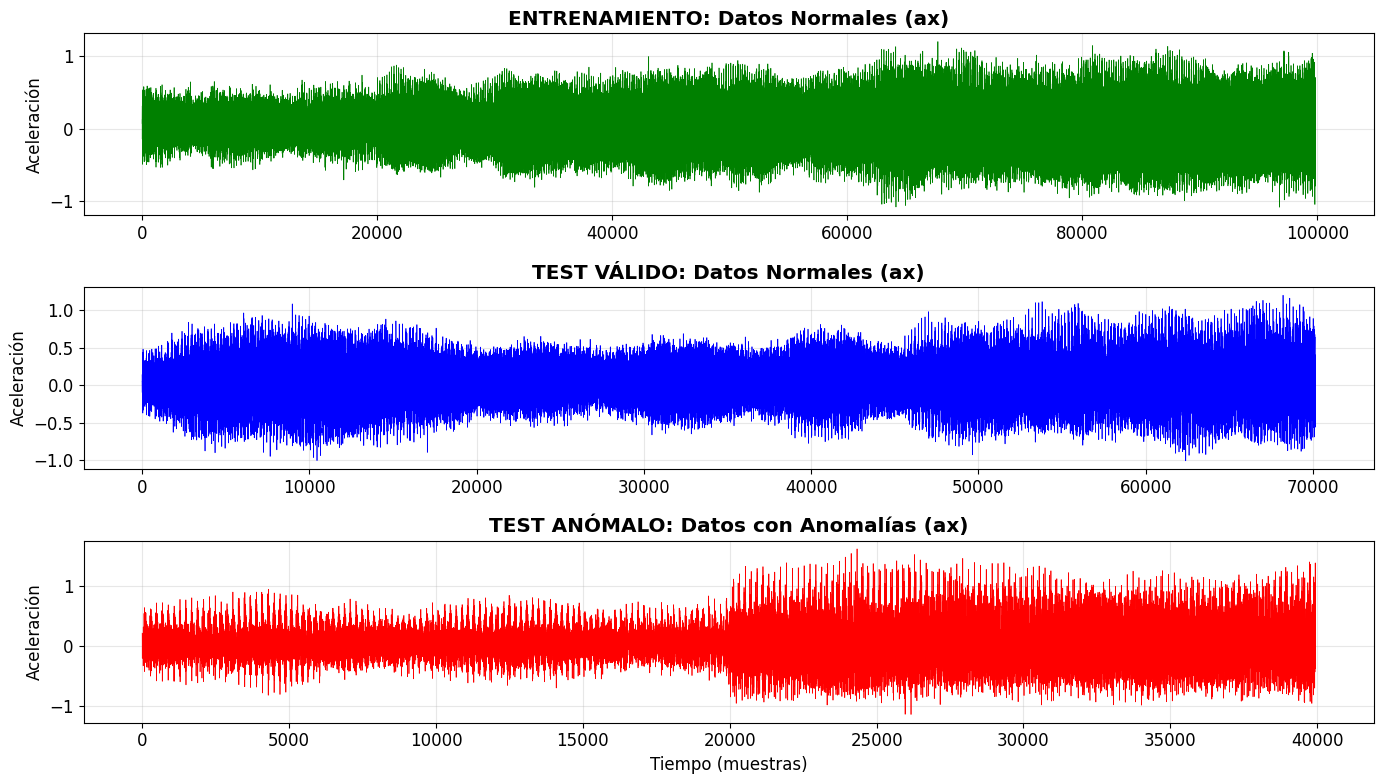

▶ Nota: Los datos de test válidos deberían tener patrones similares al entrenamiento.
▶ Los datos con anomalías deberían mostrar comportamientos diferentes.


In [17]:
fig, axes = plt.subplots(3, 1, figsize=(14, 8))

# Graficar una muestra de cada tipo de datos

# 1. Datos de entrenamiento (normales)
axes[0].plot(X_train, color='green', linewidth=0.5)
axes[0].set_title('ENTRENAMIENTO: Datos Normales (ax)', fontweight='bold')
axes[0].set_ylabel('Aceleración')
axes[0].grid(True, alpha=0.3)

# 2. Datos de test válidos (normales)
axes[1].plot(X_test_valid, color='blue', linewidth=0.5)
axes[1].set_title('TEST VÁLIDO: Datos Normales (ax)', fontweight='bold')
axes[1].set_ylabel('Aceleración')
axes[1].grid(True, alpha=0.3)

# 3. Datos de test con anomalías
axes[2].plot(X_test_anomaly, color='red', linewidth=0.5)
axes[2].set_title('TEST ANÓMALO: Datos con Anomalías (ax)', fontweight='bold')
axes[2].set_ylabel('Aceleración')
axes[2].set_xlabel('Tiempo (muestras)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("▶ Nota: Los datos de test válidos deberían tener patrones similares al entrenamiento.")
print("▶ Los datos con anomalías deberían mostrar comportamientos diferentes.")

## 4. Enventanado de Series Temporales

El enventanado (windowing) consiste en dividir la serie temporal en segmentos superpuestos.

### Parámetros configurables:
- **`window_size`**: Tamaño de cada ventana (número de muestras por ventana)
- **`stride`**: Deslizamiento entre ventanas (paso entre ventanas consecutivas)

Ejemplo: si `window_size=1000` y `stride=200`, cada ventana contiene 1000 muestras, 
y la siguiente ventana comienza 200 muestras después.

In [18]:
# ============================================================
# PARÁMETROS DE ENVENTANADO (MODIFICABLES)
# ============================================================
window_size = 1000   # Tamaño de cada ventana
stride = 200         # Deslizamiento entre ventanas

print("=" * 60)
print("PARÁMETROS DE ENVENTANADO")
print("=" * 60)
print(f"✓ Tamaño de ventana: {window_size} muestras")
print(f"✓ Deslizamiento: {stride} muestras")
print(f"✓ Solapamiento: {window_size - stride} muestras ({100*(window_size-stride)/window_size:.1f}%)")
print()

# Función simple para crear ventanas deslizantes
def create_windows(signal, window_size, stride):
    """Crea ventanas deslizantes a partir de una señal 1D."""
    n_samples = len(signal)
    n_windows = (n_samples - window_size) // stride + 1
    
    windows = np.zeros((n_windows, window_size))
    for i in range(n_windows):
        start = i * stride
        end = start + window_size
        windows[i] = signal[start:end]
    
    return windows

# Crear ventanas para datos de entrenamiento
windows_train = create_windows(X_train, window_size, stride)
print(f"✓ Ventanas de entrenamiento: {windows_train.shape}")
print(f"  (número de ventanas, tamaño de ventana)")
print()

# Crear ventanas para test combinado (válidos + anomalías)
windows_test = create_windows(X_test_combined, window_size, stride)

# Ajustar etiquetas al número de ventanas
# Cada ventana hereda la etiqueta de su muestra central
n_test_windows = windows_test.shape[0]
labels_test = []
for i in range(n_test_windows):
    center_idx = i * stride + window_size // 2
    if center_idx < len(y_test_combined):
        labels_test.append(y_test_combined[center_idx])
    else:
        labels_test.append(y_test_combined[-1])

labels_test = np.array(labels_test)

print(f"✓ Ventanas de test: {windows_test.shape}")
print(f"✓ Etiquetas de test (ventanas): {labels_test.shape}")
print(f"  - Ventanas normales: {int(labels_test.sum())}")
print(f"  - Ventanas anómalas: {int((1 - labels_test).sum())}")

PARÁMETROS DE ENVENTANADO
✓ Tamaño de ventana: 1000 muestras
✓ Deslizamiento: 200 muestras
✓ Solapamiento: 800 muestras (80.0%)

✓ Ventanas de entrenamiento: (495, 1000)
  (número de ventanas, tamaño de ventana)

✓ Ventanas de test: (546, 1000)
✓ Etiquetas de test (ventanas): (546,)
  - Ventanas normales: 349
  - Ventanas anómalas: 197


## 5. Detector de Anomalías: KNN (K-Nearest Neighbors)

El método KNN detecta anomalías calculando la **distancia promedio** a los K vecinos más cercanos.

### Idea:
- **Datos normales**: están cerca de otros datos normales (distancia pequeña)
- **Anomalías**: están lejos de los datos normales (distancia grande)

### Parámetros configurables:
- **`n_neighbors`**: Número de vecinos cercanos a considerar (K)

DETECTOR KNN
✓ Número de vecinos (K): 10

✓ Modelo KNN entrenado con 495 ventanas normales

✓ Scores calculados para 546 ventanas de test
  - Score mínimo: 5.5388
  - Score máximo: 13.7339
  - Score promedio: 8.9564



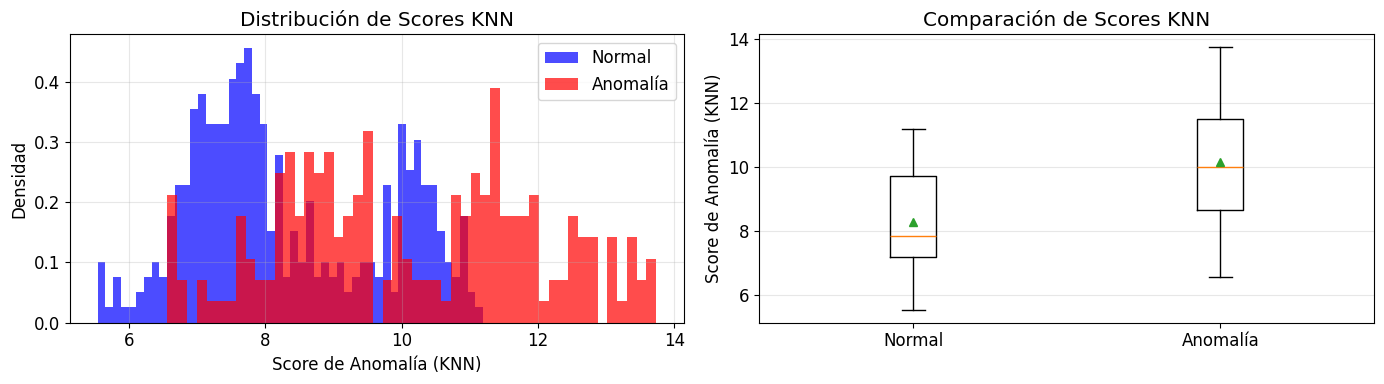

▶ Si el detector funciona bien, las anomalías deberían tener scores más altos.


In [21]:
# ============================================================
# PARÁMETROS DEL DETECTOR KNN (MODIFICABLES)
# ============================================================
n_neighbors = 10    # Número de vecinos cercanos (K)

print("=" * 60)
print("DETECTOR KNN")
print("=" * 60)
print(f"✓ Número de vecinos (K): {n_neighbors}")
print()

# 1. Entrenar KNN con las ventanas de entrenamiento
knn_model = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
knn_model.fit(windows_train)

print(f"✓ Modelo KNN entrenado con {windows_train.shape[0]} ventanas normales")
print()

# 2. Calcular scores de anomalía para datos de test
# Score = distancia promedio a los K vecinos más cercanos
distances_test, indices_test = knn_model.kneighbors(windows_test)

# El score de anomalía es la distancia promedio
scores_knn = distances_test.mean(axis=1)

print(f"✓ Scores calculados para {len(scores_knn)} ventanas de test")
print(f"  - Score mínimo: {scores_knn.min():.4f}")
print(f"  - Score máximo: {scores_knn.max():.4f}")
print(f"  - Score promedio: {scores_knn.mean():.4f}")
print()

# Visualizar distribución de scores
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histograma de scores separado por clase
axes[0].hist(scores_knn[labels_test == 1], bins=50, alpha=0.7, 
             label='Normal', color='blue', density=True)
axes[0].hist(scores_knn[labels_test == 0], bins=50, alpha=0.7, 
             label='Anomalía', color='red', density=True)
axes[0].set_xlabel('Score de Anomalía (KNN)')
axes[0].set_ylabel('Densidad')
axes[0].set_title('Distribución de Scores KNN')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot comparativo
axes[1].boxplot([scores_knn[labels_test == 1], scores_knn[labels_test == 0]],
                tick_labels=['Normal', 'Anomalía'],
                showmeans=True)
axes[1].set_ylabel('Score de Anomalía (KNN)')
axes[1].set_title('Comparación de Scores KNN')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("▶ Si el detector funciona bien, las anomalías deberían tener scores más altos.")

## 6. Evaluar Métricas KNN y Curva ROC

Calculamos métricas estándar para evaluar el rendimiento del detector KNN:

### Métricas de Evaluación

#### Matriz de Confusión (Referencia)
```
                Predicción
              Positivo  Negativo
Real  Positivo   TP       FN
      Negativo   FP       TN

TP = Verdadero Positivo (anomalía detectada correctamente)
FN = Falso Negativo (anomalía no detectada)
FP = Falso Positivo (normal detectado como anomalía)
TN = Verdadero Negativo (normal detectado correctamente)
```

#### 1. **AUC-ROC (Area Under the Receiver Operating Characteristic Curve)**
- **Fórmula**: Área bajo la curva que grafica TPR vs FPR para diferentes umbrales
- **Rango**: 0 a 1
- **Interpretación**: 
  - AUC = 1.0: Clasificador perfecto
  - AUC = 0.5: Clasificador sin capacidad discriminativa (azar)
  - AUC = 0.0: Clasificador completamente invertido
  - **Ventaja**: Invariante al desequilibrio de clases, evalúa en todos los umbrales

#### 2. **Precisión (Precision)**
- **Fórmula**: $P = \frac{TP}{TP + FP}$
- **Rango**: 0 a 1
- **Interpretación**: De todas las anomalías detectadas, ¿cuántas son reales?
  - Alta precisión = pocas falsas alarmas
  - Importante cuando los falsos positivos son costosos

#### 3. **Recall (Sensibilidad o Cobertura)**
- **Fórmula**: $R = \frac{TP}{TP + FN}$
- **Rango**: 0 a 1
- **Interpretación**: De todas las anomalías reales, ¿cuántas detectamos?
  - Alto recall = capturamos la mayoría de anomalías
  - Importante cuando los falsos negativos son peligrosos

#### 4. **F1-Score (Media Armónica)**
- **Fórmula**: $F1 = 2 \cdot \frac{P \cdot R}{P + R}$
- **Rango**: 0 a 1
- **Interpretación**: Balance entre precisión y recall
  - Útil cuando hay trade-off entre precisión y recall
  - Mejor que promedios simples para datos desequilibrados

#### 5. **Accuracy (Exactitud)**
- **Fórmula**: $Acc = \frac{TP + TN}{TP + TN + FP + FN}$
- **Rango**: 0 a 1
- **Interpretación**: Proporción total de predicciones correctas
  - ⚠️ Engañosa con datos desequilibrados
  - No recomendada como métrica principal en detección de anomalías



RESULTADOS KNN
✓ AUC-ROC: 0.7837
✓ Umbral óptimo: 8.2661
✓ Precisión: 0.5490
✓ Recall: 0.8528
✓ F1-Score: 0.6680
✓ Accuracy: 0.6941



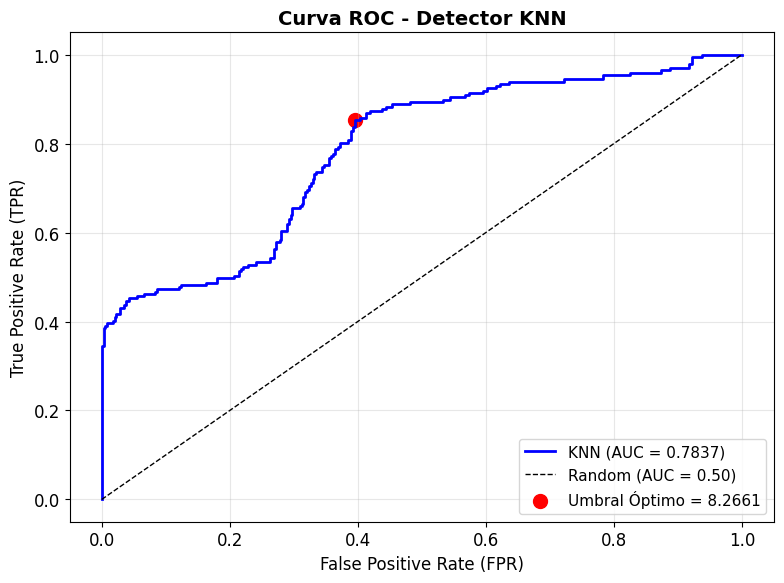


INTERPRETACIÓN
• Cuanto más cerca esté la curva ROC de la esquina superior izquierda, mejor.
• Un AUC-ROC cercano a 1.0 indica un detector excelente.
• Un AUC-ROC de 0.5 indica rendimiento aleatorio.
• La métrica AUC-ROC es independiente del umbral de clasificación.


In [30]:
# Para la curva ROC necesitamos invertir las etiquetas:
# ROC espera: 1 = anomalía (positivo), 0 = normal (negativo)
# Tenemos: 1 = normal, 0 = anomalía
# Por eso invertimos
y_true_roc = 1 - labels_test  # Ahora: 1 = anomalía, 0 = normal

# Calcular curva ROC
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_true_roc, scores_knn)
auc_knn = auc(fpr_knn, tpr_knn)

# Encontrar umbral óptimo (maximiza TPR - FPR)
optimal_idx = np.argmax(tpr_knn - fpr_knn)
optimal_threshold_knn = thresholds_knn[optimal_idx]

# Clasificar usando el umbral óptimo
y_pred_knn = (scores_knn >= optimal_threshold_knn).astype(int)

# Calcular métricas de clasificación con umbral óptimo
tn, fp, fn, tp = confusion_matrix(y_true_roc, y_pred_knn).ravel()
precision_knn = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_knn = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_knn = 2 * (precision_knn * recall_knn) / (precision_knn + recall_knn) if (precision_knn + recall_knn) > 0 else 0
accuracy_knn = (tp + tn) / (tp + tn + fp + fn)

print("=" * 60)
print("RESULTADOS KNN")
print("=" * 60)
print(f"✓ AUC-ROC: {auc_knn:.4f}")
print(f"✓ Umbral óptimo: {optimal_threshold_knn:.4f}")
print(f"✓ Precisión: {precision_knn:.4f}")
print(f"✓ Recall: {recall_knn:.4f}")
print(f"✓ F1-Score: {f1_knn:.4f}")
print(f"✓ Accuracy: {accuracy_knn:.4f}")
print()

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, linewidth=2, label=f'KNN (AUC = {auc_knn:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.50)')
plt.scatter(fpr_knn[optimal_idx], tpr_knn[optimal_idx], s=100, c='red', 
            marker='o', label=f'Umbral Óptimo = {optimal_threshold_knn:.4f}')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Curva ROC - Detector KNN', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("INTERPRETACIÓN")
print("=" * 80)
print("• Cuanto más cerca esté la curva ROC de la esquina superior izquierda, mejor.")
print("• Un AUC-ROC cercano a 1.0 indica un detector excelente.")
print("• Un AUC-ROC de 0.5 indica rendimiento aleatorio.")
print("• La métrica AUC-ROC es independiente del umbral de clasificación.")
print("=" * 80)

## 7. Detector de Anomalías: PCA (Principal Component Analysis)

El método PCA detecta anomalías usando el **error de reconstrucción**.

### Idea:
1. PCA aprende los patrones principales de los datos normales
2. Proyecta los datos a un espacio de menor dimensión
3. Reconstruye los datos originales desde ese espacio reducido
4. **Datos normales**: se reconstruyen bien (error bajo)
5. **Anomalías**: no se reconstruyen bien (error alto)

### Parámetros configurables:
- **`n_components`**: Número de componentes principales (o varianza a retener, e.g., 0.95 = 95%)

DETECTOR PCA
✓ Componentes principales: 0.95
  (Reteniendo 95% de la varianza)

✓ Modelo PCA entrenado con 495 ventanas normales
✓ Número de componentes usados: 32
✓ Varianza explicada: 95.12%

✓ Scores calculados para 546 ventanas de test
  - Score mínimo: 0.007353
  - Score máximo: 0.083052
  - Score promedio: 0.025473



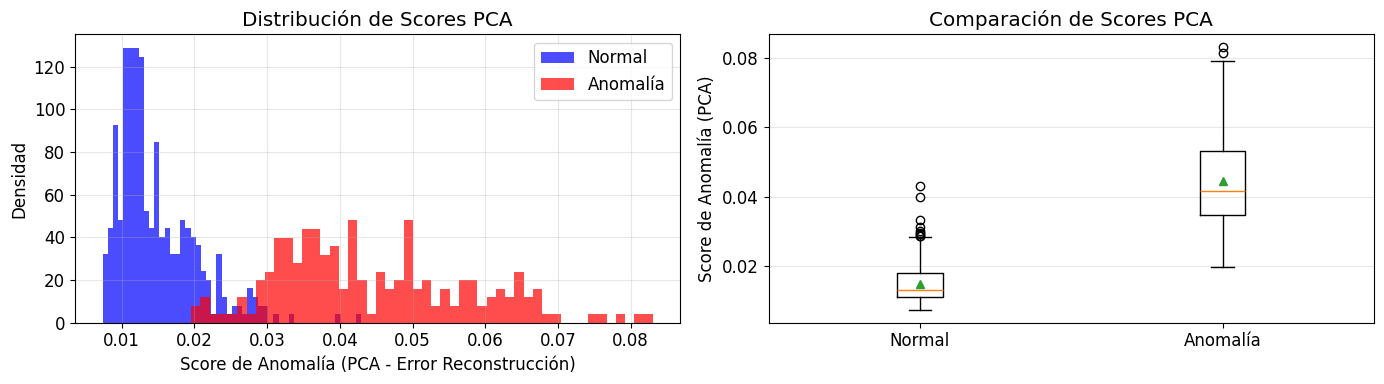

▶ Si el detector funciona bien, las anomalías deberían tener scores más altos.


In [24]:
# ============================================================
# PARÁMETROS DEL DETECTOR PCA (MODIFICABLES)
# ============================================================
n_components = 0.95  # Retener 95% de la varianza (o número entero de componentes)

print("=" * 60)
print("DETECTOR PCA")
print("=" * 60)
print(f"✓ Componentes principales: {n_components}")
if isinstance(n_components, float) and n_components < 1.0:
    print(f"  (Reteniendo {n_components*100:.0f}% de la varianza)")
print()

# 1. Entrenar PCA con las ventanas de entrenamiento
pca_model = PCA(n_components=n_components)
pca_model.fit(windows_train)

print(f"✓ Modelo PCA entrenado con {windows_train.shape[0]} ventanas normales")
print(f"✓ Número de componentes usados: {pca_model.n_components_}")
print(f"✓ Varianza explicada: {pca_model.explained_variance_ratio_.sum()*100:.2f}%")
print()

# 2. Calcular error de reconstrucción para datos de test
# Proyectar al espacio PCA
test_transformed = pca_model.transform(windows_test)

# Reconstruir desde el espacio PCA
test_reconstructed = pca_model.inverse_transform(test_transformed)

# Calcular error de reconstrucción (MSE por ventana)
reconstruction_errors = np.mean((windows_test - test_reconstructed) ** 2, axis=1)

# El score de anomalía es el error de reconstrucción
scores_pca = reconstruction_errors

print(f"✓ Scores calculados para {len(scores_pca)} ventanas de test")
print(f"  - Score mínimo: {scores_pca.min():.6f}")
print(f"  - Score máximo: {scores_pca.max():.6f}")
print(f"  - Score promedio: {scores_pca.mean():.6f}")
print()

# Visualizar distribución de scores
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histograma de scores separado por clase
axes[0].hist(scores_pca[labels_test == 1], bins=50, alpha=0.7, 
             label='Normal', color='blue', density=True)
axes[0].hist(scores_pca[labels_test == 0], bins=50, alpha=0.7, 
             label='Anomalía', color='red', density=True)
axes[0].set_xlabel('Score de Anomalía (PCA - Error Reconstrucción)')
axes[0].set_ylabel('Densidad')
axes[0].set_title('Distribución de Scores PCA')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot comparativo
axes[1].boxplot([scores_pca[labels_test == 1], scores_pca[labels_test == 0]],
                tick_labels=['Normal', 'Anomalía'],
                showmeans=True)
axes[1].set_ylabel('Score de Anomalía (PCA)')
axes[1].set_title('Comparación de Scores PCA')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("▶ Si el detector funciona bien, las anomalías deberían tener scores más altos.")

## 8. Evaluar Métricas PCA y Curva ROC

Calculamos las mismas métricas para el detector PCA.

RESULTADOS PCA
✓ AUC-ROC: 0.9915
✓ Umbral óptimo: 0.029028
✓ Precisión: 0.9635
✓ Recall: 0.9391
✓ F1-Score: 0.9512
✓ Accuracy: 0.9652



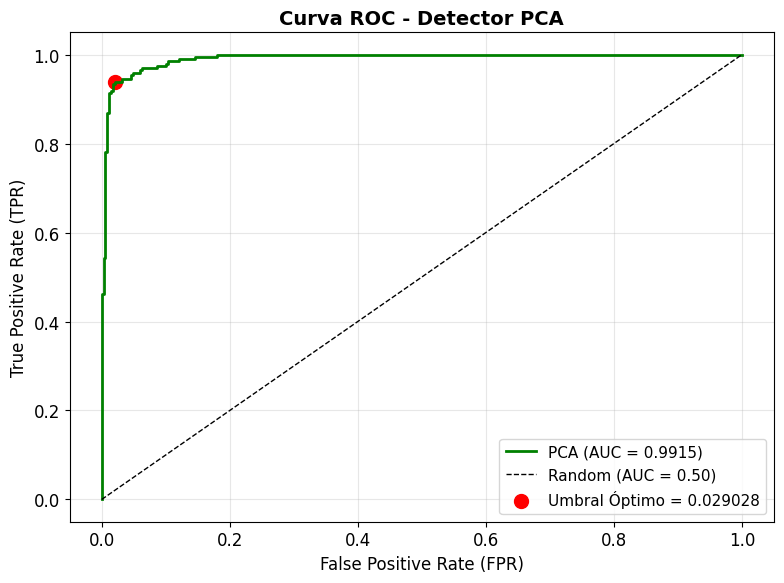

In [26]:
# Calcular curva ROC para PCA
fpr_pca, tpr_pca, thresholds_pca = roc_curve(y_true_roc, scores_pca)
auc_pca = auc(fpr_pca, tpr_pca)

# Encontrar umbral óptimo (maximiza TPR - FPR)
optimal_idx_pca = np.argmax(tpr_pca - fpr_pca)
optimal_threshold_pca = thresholds_pca[optimal_idx_pca]

# Clasificar usando el umbral óptimo
y_pred_pca = (scores_pca >= optimal_threshold_pca).astype(int)

# Calcular métricas de clasificación
tn, fp, fn, tp = confusion_matrix(y_true_roc, y_pred_pca).ravel()
precision_pca = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_pca = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_pca = 2 * (precision_pca * recall_pca) / (precision_pca + recall_pca) if (precision_pca + recall_pca) > 0 else 0
accuracy_pca = (tp + tn) / (tp + tn + fp + fn)

print("=" * 60)
print("RESULTADOS PCA")
print("=" * 60)
print(f"✓ AUC-ROC: {auc_pca:.4f}")
print(f"✓ Umbral óptimo: {optimal_threshold_pca:.6f}")
print(f"✓ Precisión: {precision_pca:.4f}")
print(f"✓ Recall: {recall_pca:.4f}")
print(f"✓ F1-Score: {f1_pca:.4f}")
print(f"✓ Accuracy: {accuracy_pca:.4f}")
print()

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_pca, tpr_pca, linewidth=2, label=f'PCA (AUC = {auc_pca:.4f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.50)')
plt.scatter(fpr_pca[optimal_idx_pca], tpr_pca[optimal_idx_pca], s=100, c='red', 
            marker='o', label=f'Umbral Óptimo = {optimal_threshold_pca:.6f}')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Curva ROC - Detector PCA', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Detector de Anomalías: Isolation Forest

El **Isolation Forest** es un algoritmo basado en árboles que detecta anomalías de manera muy diferente a KNN y PCA.

### Idea Fundamental:
- Las **anomalías son puntos aislados** que se pueden separar rápidamente
- Las **muestras normales requieren muchas particiones** para aislarse
- El algoritmo construye árboles aleatorios que dividen el espacio iterativamente
- **Score de anomalía** = número medio de particiones necesarias para aislar un punto
  - Pocos pasos = anomalía (score alto)
  - Muchos pasos = normal (score bajo)

### Ventajas:
- ✅ No requiere definir distancias (como KNN)
- ✅ No requiere reconstrucción (como PCA)
- ✅ Muy eficiente computacionalmente
- ✅ Funciona bien en espacios altos

### Parámetros configurables:
- **`n_estimators`**: Número de árboles (más = mejor pero más lento)
- **`contamination`**: Proporción esperada de anomalías (para calibrar)

DETECTOR ISOLATION FOREST
✓ Número de árboles: 5000
✓ Contaminación esperada: 10.0%

✓ Modelo entrenado con 495 ventanas
✓ Evaluado en 546 ventanas
  - Score mínimo: -0.0703
  - Score máximo: 0.0485
  - Score medio: -0.0161



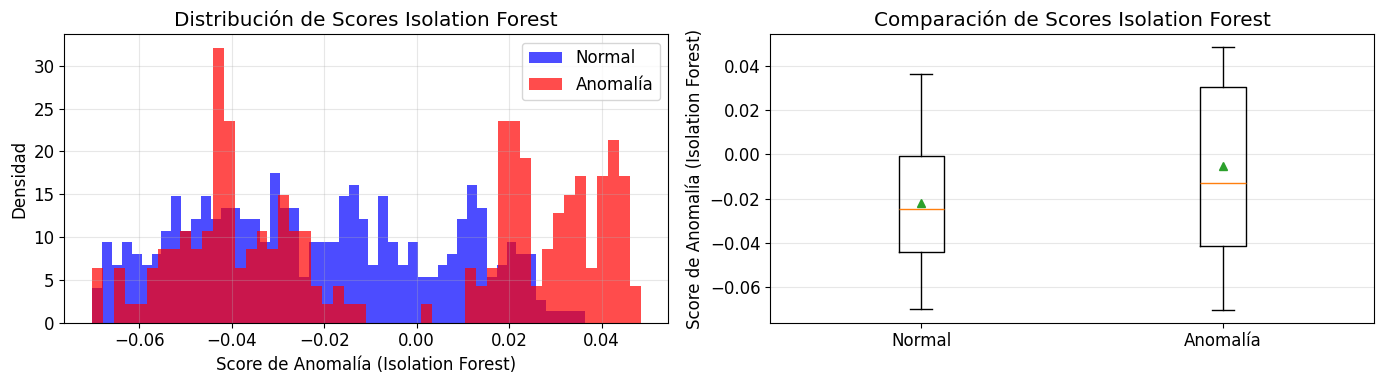

▶ Si el detector funciona bien, las anomalías deberían tener scores más altos.


In [ ]:
from sklearn.ensemble import IsolationForest

# ============================================================
# PARÁMETROS DEL DETECTOR ISOLATION FOREST (MODIFICABLES)
# ============================================================
n_estimators_if = 100        # Número de árboles
contamination_if = 0.1       # Proporción esperada de anomalías (~10%)

print("=" * 60)
print("DETECTOR ISOLATION FOREST")
print("=" * 60)
print(f"✓ Número de árboles: {n_estimators_if}")
print(f"✓ Contaminación esperada: {contamination_if*100:.1f}%")
print()

# 1. Entrenar Isolation Forest con las ventanas de entrenamiento
if_model = IsolationForest(
    n_estimators=n_estimators_if,
    contamination=contamination_if,
    random_state=42
)
if_model.fit(windows_train)

# 2. Calcular scores para el conjunto de test
# En sklearn, IsolationForest.decision_function() da scores negativos para anomalías
# Convertimos para que anomalía = score alto (como en KNN/PCA)
scores_if_raw = if_model.decision_function(windows_test)
scores_if = -scores_if_raw  # Invertimos para que anomalía = score alto

print(f"✓ Modelo entrenado con {windows_train.shape[0]} ventanas")
print(f"✓ Evaluado en {windows_test.shape[0]} ventanas")
print(f"  - Score mínimo: {scores_if.min():.4f}")
print(f"  - Score máximo: {scores_if.max():.4f}")
print(f"  - Score medio: {scores_if.mean():.4f}")
print()

# Visualizar distribución de scores
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histograma de scores separado por clase
axes[0].hist(scores_if[labels_test == 1], bins=50, alpha=0.7, 
             label='Normal', color='blue', density=True)
axes[0].hist(scores_if[labels_test == 0], bins=50, alpha=0.7, 
             label='Anomalía', color='red', density=True)
axes[0].set_xlabel('Score de Anomalía (Isolation Forest)')
axes[0].set_ylabel('Densidad')
axes[0].set_title('Distribución de Scores Isolation Forest')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot comparativo
axes[1].boxplot([scores_if[labels_test == 1], scores_if[labels_test == 0]],
                tick_labels=['Normal', 'Anomalía'],
                showmeans=True)
axes[1].set_ylabel('Score de Anomalía (Isolation Forest)')
axes[1].set_title('Comparación de Scores Isolation Forest')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("▶ Si el detector funciona bien, las anomalías deberían tener scores más altos.")

## 10. Evaluar Métricas Isolation Forest y Curva ROC

Calculamos métricas estándar para evaluar el rendimiento del detector Isolation Forest.

RESULTADOS ISOLATION FOREST
✓ AUC-ROC: 0.6314
✓ Umbral óptimo: 0.0216
✓ Precisión: 0.8878
✓ Recall: 0.4416
✓ F1-Score: 0.5898
✓ Accuracy: 0.7784



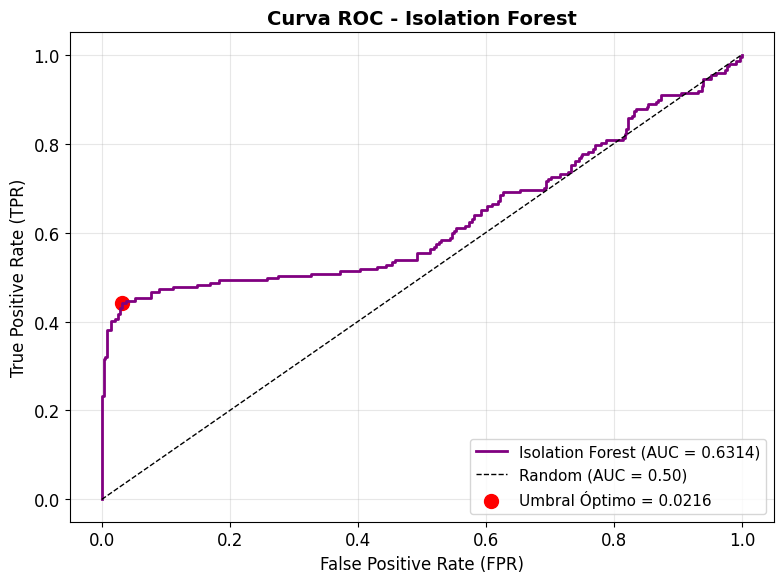

In [41]:
# Calcular curva ROC
fpr_if, tpr_if, thresholds_if = roc_curve(y_true_roc, scores_if)
auc_if = auc(fpr_if, tpr_if)

# Encontrar umbral óptimo
optimal_idx_if = np.argmax(tpr_if - fpr_if)
optimal_threshold_if = thresholds_if[optimal_idx_if]

# Clasificar usando el umbral óptimo
y_pred_if = (scores_if >= optimal_threshold_if).astype(int)

# Calcular métricas de clasificación
tn, fp, fn, tp = confusion_matrix(y_true_roc, y_pred_if).ravel()
precision_if = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_if = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_if = 2 * (precision_if * recall_if) / (precision_if + recall_if) if (precision_if + recall_if) > 0 else 0
accuracy_if = (tp + tn) / (tp + tn + fp + fn)

print("=" * 60)
print("RESULTADOS ISOLATION FOREST")
print("=" * 60)
print(f"✓ AUC-ROC: {auc_if:.4f}")
print(f"✓ Umbral óptimo: {optimal_threshold_if:.4f}")
print(f"✓ Precisión: {precision_if:.4f}")
print(f"✓ Recall: {recall_if:.4f}")
print(f"✓ F1-Score: {f1_if:.4f}")
print(f"✓ Accuracy: {accuracy_if:.4f}")
print()

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_if, tpr_if, linewidth=2, label=f'Isolation Forest (AUC = {auc_if:.4f})', color='purple')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.50)')
plt.scatter(fpr_if[optimal_idx_if], tpr_if[optimal_idx_if], s=100, c='red', 
            marker='o', label=f'Umbral Óptimo = {optimal_threshold_if:.4f}')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Curva ROC - Isolation Forest', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Comparar Resultados de los Tres Métodos

Ahora comparamos el rendimiento de KNN, PCA e Isolation Forest para facilitar la selección del mejor método.

In [38]:
# Crear tabla de comparación
results_comparison = pd.DataFrame({
    'Método': ['KNN', 'PCA', 'Isolation Forest'],
    'AUC-ROC': [auc_knn, auc_pca, auc_if],
    'Precisión': [precision_knn, precision_pca, precision_if],
    'Recall': [recall_knn, recall_pca, recall_if],
    'F1-Score': [f1_knn, f1_pca, f1_if],
    'Accuracy': [accuracy_knn, accuracy_pca, accuracy_if]
})

print("=" * 80)
print("TABLA COMPARATIVA DE MÉTODOS")
print("=" * 80)
print(results_comparison.to_string(index=False))
print("=" * 80)
print()

# Determinar el mejor método por AUC
best_method_idx = results_comparison['AUC-ROC'].idxmax()
best_method = results_comparison.loc[best_method_idx, 'Método']
best_auc = results_comparison.loc[best_method_idx, 'AUC-ROC']
print(f"🏆 MEJOR MÉTODO (por AUC-ROC): {best_method} (AUC = {best_auc:.4f})")
print()

TABLA COMPARATIVA DE MÉTODOS
          Método  AUC-ROC  Precisión   Recall  F1-Score  Accuracy
             KNN 0.783675   0.549020 0.852792  0.667992  0.694139
             PCA 0.991462   0.963542 0.939086  0.951157  0.965201
Isolation Forest 0.635361   0.596491 0.517766  0.554348  0.699634

🏆 MEJOR MÉTODO (por AUC-ROC): PCA (AUC = 0.9915)



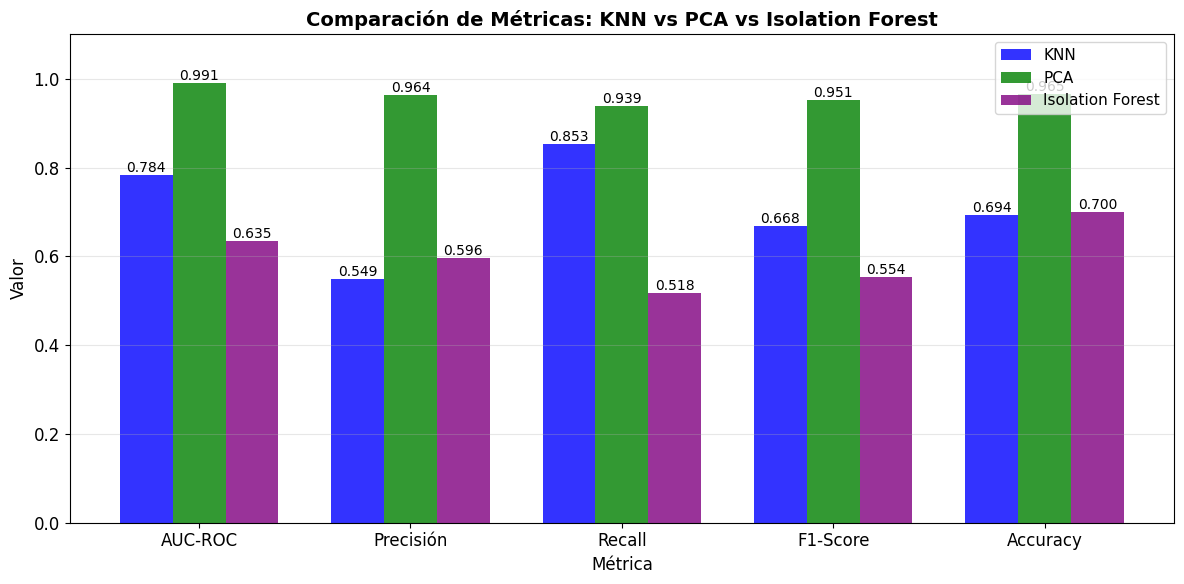

In [39]:
# Gráfico de barras comparativo
metrics_to_plot = ['AUC-ROC', 'Precisión', 'Recall', 'F1-Score', 'Accuracy']
x = np.arange(len(metrics_to_plot))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

knn_values = [auc_knn, precision_knn, recall_knn, f1_knn, accuracy_knn]
pca_values = [auc_pca, precision_pca, recall_pca, f1_pca, accuracy_pca]
if_values = [auc_if, precision_if, recall_if, f1_if, accuracy_if]

bars1 = ax.bar(x - width, knn_values, width, label='KNN', color='blue', alpha=0.8)
bars2 = ax.bar(x, pca_values, width, label='PCA', color='green', alpha=0.8)
bars3 = ax.bar(x + width, if_values, width, label='Isolation Forest', color='purple', alpha=0.8)

# Añadir valores en las barras
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Métrica', fontsize=12)
ax.set_ylabel('Valor', fontsize=12)
ax.set_title('Comparación de Métricas: KNN vs PCA vs Isolation Forest', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 12. Conclusiones y Extensión a Otros Métodos

### Resumen
En este tutorial hemos:
1. ✅ Cargado datos de aceleración del dataset ICANN (canal `ax`)
2. ✅ Aplicado enventanado a las series temporales
3. ✅ Implementado tres detectores de anomalías: **KNN**, **PCA** e **Isolation Forest**
4. ✅ Evaluado el rendimiento con métricas estándar (AUC-ROC, precisión, recall, F1)
5. ✅ Comparado los tres métodos visual y numéricamente

### Parámetros Modificables
El código está diseñado para que puedas experimentar fácilmente modificando:

**Enventanado:**
- `window_size`: Tamaño de las ventanas
- `stride`: Deslizamiento entre ventanas

**KNN:**
- `n_neighbors`: Número de vecinos cercanos (K)

**PCA:**
- `n_components`: Número de componentes o varianza a retener

**Isolation Forest:**
- `n_estimators`: Número de árboles
- `contamination`: Proporción esperada de anomalías

### Cómo Extender a Otros Métodos

Para añadir un nuevo método (ej. Autoencoder, One-Class SVM, etc.):

1. **Entrenar el modelo** con `windows_train`
2. **Calcular scores** para `windows_test` (mayor score = mayor probabilidad de anomalía)
3. **Calcular métricas** usando el mismo código de evaluación
4. **Añadir a la comparación** actualizando `results_comparison`

Ejemplo estructura:
```python
# Entrenar nuevo método
model_nuevo = MetodoNuevo(parametros)
model_nuevo.fit(windows_train)

# Calcular scores
scores_nuevo = model_nuevo.predict_scores(windows_test)

# Calcular métricas (igual que KNN/PCA/IF)
fpr_nuevo, tpr_nuevo, _ = roc_curve(y_true_roc, scores_nuevo)
auc_nuevo = auc(fpr_nuevo, tpr_nuevo)
# ... (resto de métricas)

# Añadir a la tabla comparativa
results_comparison = pd.concat([results_comparison, 
    pd.DataFrame({'Método': ['Nuevo'], 'AUC-ROC': [auc_nuevo], ...})
])
```

### Notas Finales
- Este código está diseñado para ser **educativo y fácil de entender**
- Se evitaron clases y abstracciones complejas para mantenerlo **lineal**
- Todos los parámetros importantes están **claramente identificados**
- El código es **fácilmente extensible** a otros métodos de detección de anomalías

### Uso con Señales Multidimensionales (Múltiples Canales)

En muchas aplicaciones del mundo real, los datos no son unidimensionales:
- **Sensores 3D de aceleración**: 3 canales (ax, ay, az)
- **Sensores de vibración**: múltiples puntos de medición
- **Electrocardiogramas (ECG)**: múltiples derivaciones
- **Señales sísmicas**: registros de múltiples estaciones

#### Opción 1: Procesar por Canal (Recomendado para interpretabilidad)

Procesar cada canal separately y combinar resultados:

```python
# Supongamos datos con 3 canales: shape = (n_samples, 3)
# ax, ay, az = aceleración en 3 ejes

scores_combined = np.zeros(n_test_windows)

for channel_idx, channel_name in enumerate(['ax', 'ay', 'az']):
    # Extraer datos del canal
    windows_train_ch = windows_train[:, :, channel_idx]  # shape: (n_train_windows, window_size)
    windows_test_ch = windows_test[:, :, channel_idx]
    
    # Entrenar detector en este canal
    detector_ch = KNN(n_neighbors=5)
    detector_ch.fit(windows_train_ch)
    scores_ch = detector_ch.predict_scores(windows_test_ch)
    
    # Combinar scores (promedio, máximo, suma ponderada, etc.)
    scores_combined += scores_ch  # Simple suma
    
# Normalizar si usaste suma
scores_combined /= 3  # Promediar
```

#### Opción 2: Aplanar la Señal (Más simple, menos interpretable)

Convertir múltiples canales en un único vector:

```python
# Datos originales: (n_samples, window_size, n_channels)
# Convertir a: (n_samples, window_size * n_channels)

windows_train_flat = windows_train.reshape(windows_train.shape[0], -1)
windows_test_flat = windows_test.reshape(windows_test.shape[0], -1)

# Ahora entrenar normalmente
knn_model = NearestNeighbors(n_neighbors=5)
knn_model.fit(windows_train_flat)
scores = knn_model.kneighbors(windows_test_flat)[0].mean(axis=1)
```

**Ventajas del aplanamiento:**
- ✅ Código simple y directo
- ✅ El modelo considera correlaciones entre canales

**Desventajas:**
- ❌ Menos interpretable (¿cuál canal es anomalía?)
- ❌ Espacios dimensionales altos → más datos necesarios
- ❌ Curse of dimensionality: con pocos datos de entrenamiento, el rendimiento empeora

#### Opción 3: Reducción Dimensional Antes del Detector

Usar **PCA multidimensional** para reducir canales antes de detectar anomalías:

```python
# Aplanar primero
windows_train_flat = windows_train.reshape(windows_train.shape[0], -1)
windows_test_flat = windows_test.reshape(windows_test.shape[0], -1)

# Aplicar PCA para comprimir
pca_pre = PCA(n_components=10)  # Reducir a 10 dimensiones
windows_train_reduced = pca_pre.fit_transform(windows_train_flat)
windows_test_reduced = pca_pre.transform(windows_test_flat)

# Ahora entrenar KNN en espacio reducido
knn_model = NearestNeighbors(n_neighbors=5)
knn_model.fit(windows_train_reduced)
scores = knn_model.kneighbors(windows_test_reduced)[0].mean(axis=1)
```

#### Recomendación Práctica

| Situación | Opción Recomendada | Razón |
|-----------|-------------------|-------|
| Pocos canales (2-3) + mucho datos | Opción 1 (por canal) | Permite interpretar qué canal es anómalo |
| Muchos canales (>5) + poco datos | Opción 3 (PCA primero) | Evita curse of dimensionality |
| Prototipado rápido | Opción 2 (aplanar) | Más simple, funciona si hay datos suficientes |
| Análisis exploratorio | Opción 1 + Opción 2 | Compara ambos enfoques |